In [75]:
import pandas as pd

df_train = pd.read_csv('https://drive.google.com/uc?id=1vc5cMT-wCFaE8FwchvMwFcxTDIm6DsD-')
df_target = pd.read_csv('https://drive.google.com/uc?id=1VH1MFPLg44ooF6FseV9s-cJYOyLyZpUw')
df_test = pd.read_csv('https://drive.google.com/uc?id=1_0tcXjA1JUDcTUNJ7HvW2QuaCZy8dVja')
df_submission = pd.read_csv('https://drive.google.com/uc?id=1OoFYxWZMp-1Kc5X0EDcUNh8lWd3JfDZs')

df_train = pd.concat([df_train, df_target], axis=1)
df_test = df_test.drop('ID', axis=1)
df_train.head()

,developerCountry,countryCode,userRatingCount,primaryGenreName,downloads,deviceType,hasPrivacyLink,hasTermsOfServiceLink,hasTermsOfServiceLinkRating,isCorporateEmailScore,adSpent,appAge,averageUserRating,appContentBrandSafetyRating,appDescriptionBrandSafetyRating,mfaRating,coppaRisk
0,NORWAY,RO,127731,Sports,NaN,smartphone,True,True,low,99.0,14.017220,160.400000,4.0,medium,low,low,False
1,ADDRESS NOT LISTED IN PLAYSTORE,GLOBAL,0,Medical,50 - 100,GLOBAL,True,NaN,NaN,99.0,NaN,17.500000,0.0,NaN,low,low,False
2,UNITED ARAB EMIRATES,CZ,51143,Games,50000000 - 100000000,GLOBAL,True,True,low,0.0,31.883163,30.766667,4.0,NaN,low,low,False
3,GERMANY,GLOBAL,1074,Games,NaN,GLOBAL,True,NaN,NaN,99.0,NaN,71.533333,4.0,NaN,low,low,False
4,CANNOT IDENTIFY COUNTRY,GLOBAL,17,Tools,1000 - 5000,GLOBAL,True,NaN,NaN,99.0,NaN,52.400000,4.0,NaN,low,low,False


# EDA

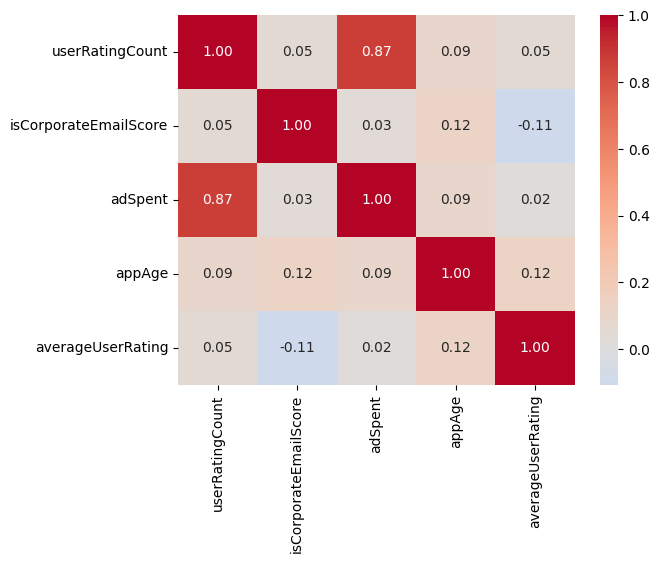

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

numerical_columns = df_train.select_dtypes(include=['float64', 'int64'])
categorical_columns = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

correlation_matrix = numerical_columns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0,)
plt.show()

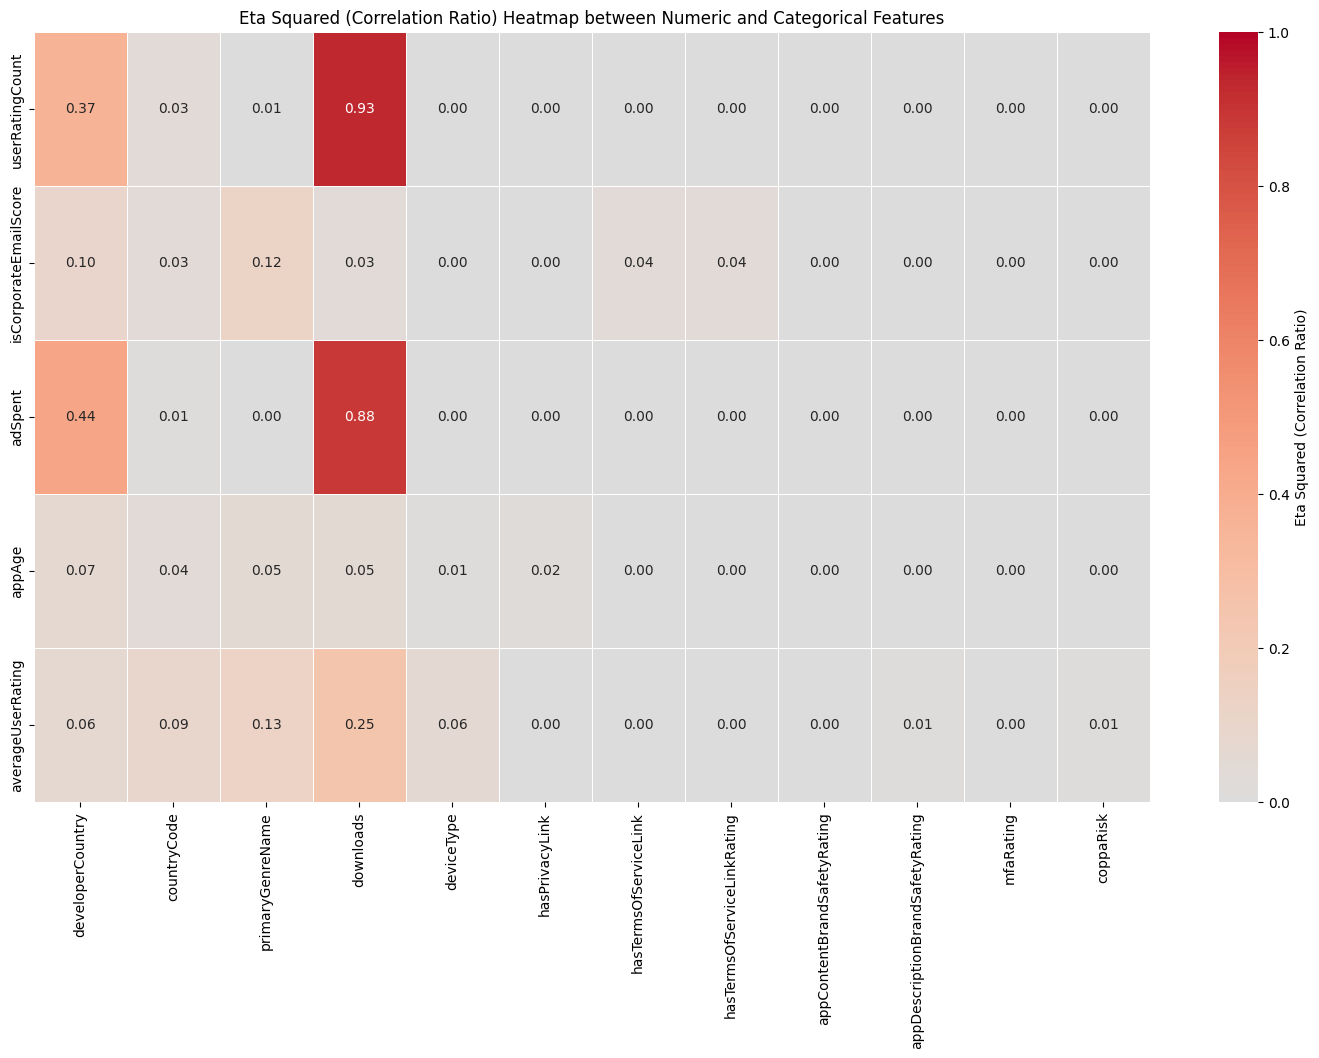

In [77]:
def eta_squared(numeric_data, categorical_data):
    """
    Calculate eta squared (correlation ratio) between numeric and categorical data.
    """
    valid_idx = ~numeric_data.isna() & ~categorical_data.isna()
    numeric_data = numeric_data[valid_idx]
    categorical_data = categorical_data[valid_idx]

    categorical_data = categorical_data.astype(str)

    groups = [numeric_data[categorical_data == category] for category in np.unique(categorical_data)]
    if len(groups) < 2:
        return 0

    f_stat, p_val = stats.f_oneway(*groups)

    overall_mean = np.mean(numeric_data)
    ss_between = sum([(len(group) * (np.mean(group) - overall_mean) ** 2) for group in groups])
    ss_total = np.sum((numeric_data - overall_mean) ** 2)
    eta_squared_value = ss_between / ss_total if ss_total > 0 else 0

    return eta_squared_value

df_train['coppaRisk'] = df_train['coppaRisk'].astype('category')

numerical = df_train.select_dtypes(include=['float64', 'int64']).columns
categorical = df_train.select_dtypes(include=['object', 'category']).columns


eta_squared_matrix = pd.DataFrame(np.zeros((len(numerical), len(categorical))),
                                  columns=categorical, index=numerical)

for num_feature in numerical:
    for cat_feature in categorical:
        eta_value = eta_squared(df_train[num_feature], df_train[cat_feature])
        eta_squared_matrix.loc[num_feature, cat_feature] = eta_value

plt.figure(figsize=(18, 10))
sns.heatmap(eta_squared_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=0, vmax=1, cbar_kws={'label': "Eta Squared (Correlation Ratio)"}, linewidths=0.5)
plt.title("Eta Squared (Correlation Ratio) Heatmap between Numeric and Categorical Features")
plt.show()

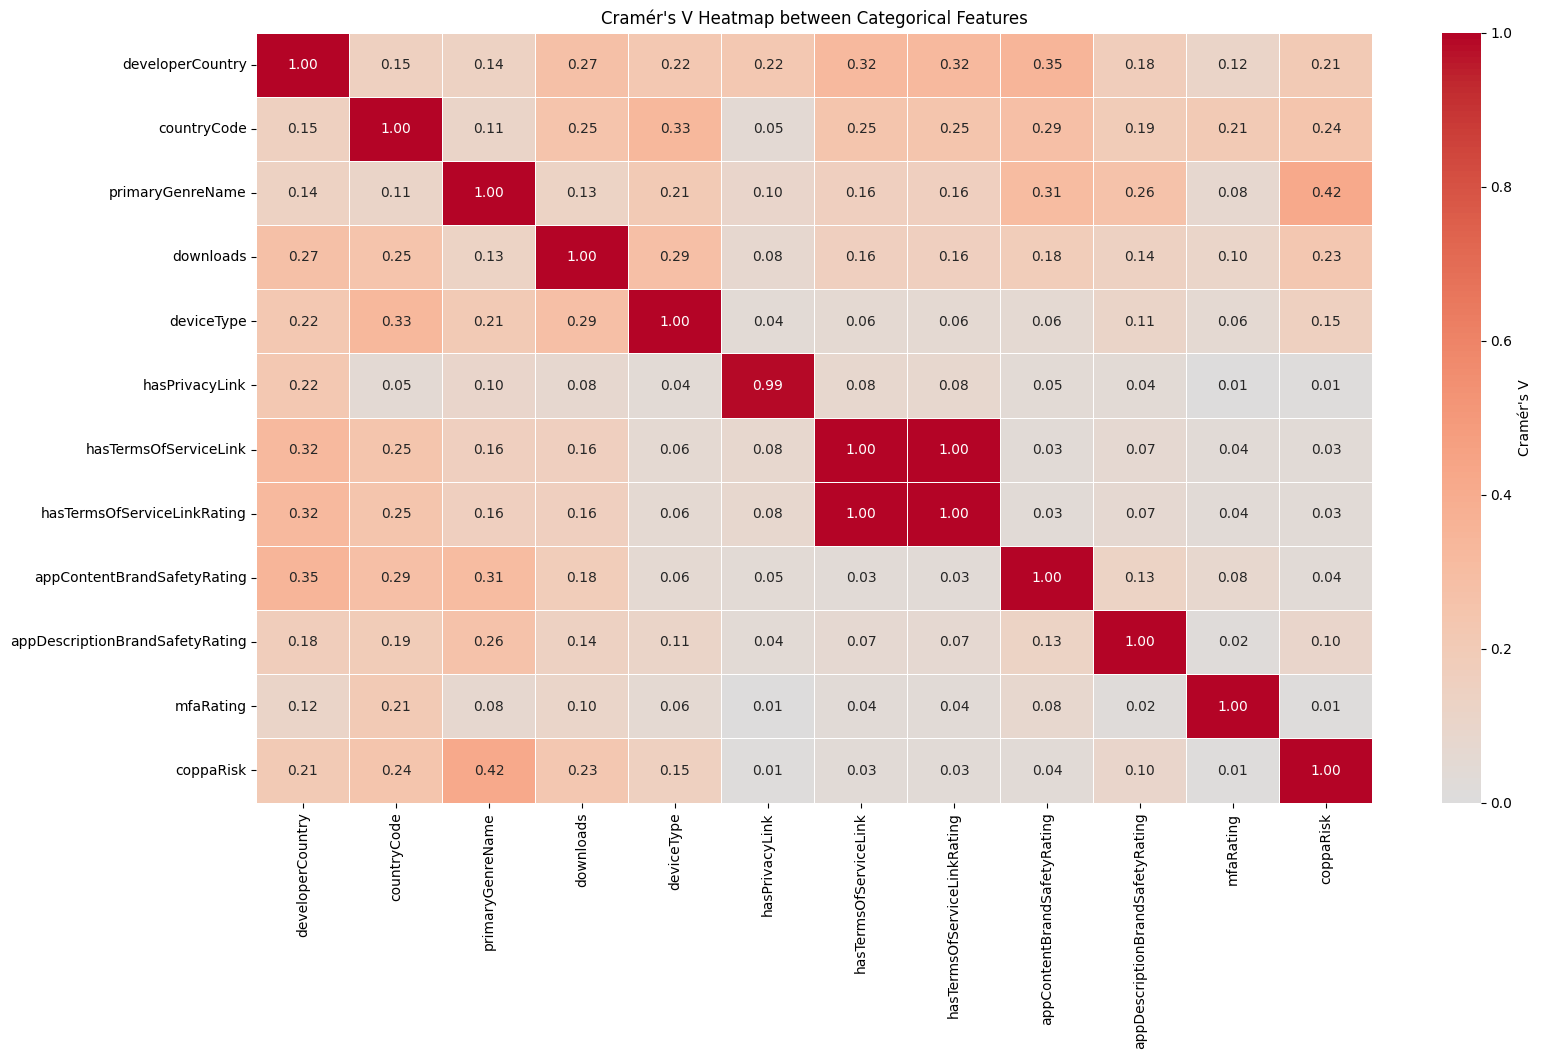

In [78]:
def cramers_v(var1,var2) :
    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    stat = stats.chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)
    mini = min(crosstab.shape)-1
    return np.sqrt(stat/(obs*mini))

cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical), len(categorical))),
                                columns=categorical, index=categorical)

for feature1 in categorical:
    for feature2 in categorical:
          cramers_v_value = cramers_v(df_train[feature1], df_train[feature2])
          cramers_v_matrix.loc[feature1, feature2] = cramers_v_value

plt.figure(figsize=(18, 10))
sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            cbar_kws={'label': "Cramér's V"}, linewidths=0.5, vmin=0, vmax=1)
plt.title("Cramér's V Heatmap between Categorical Features")
plt.show()

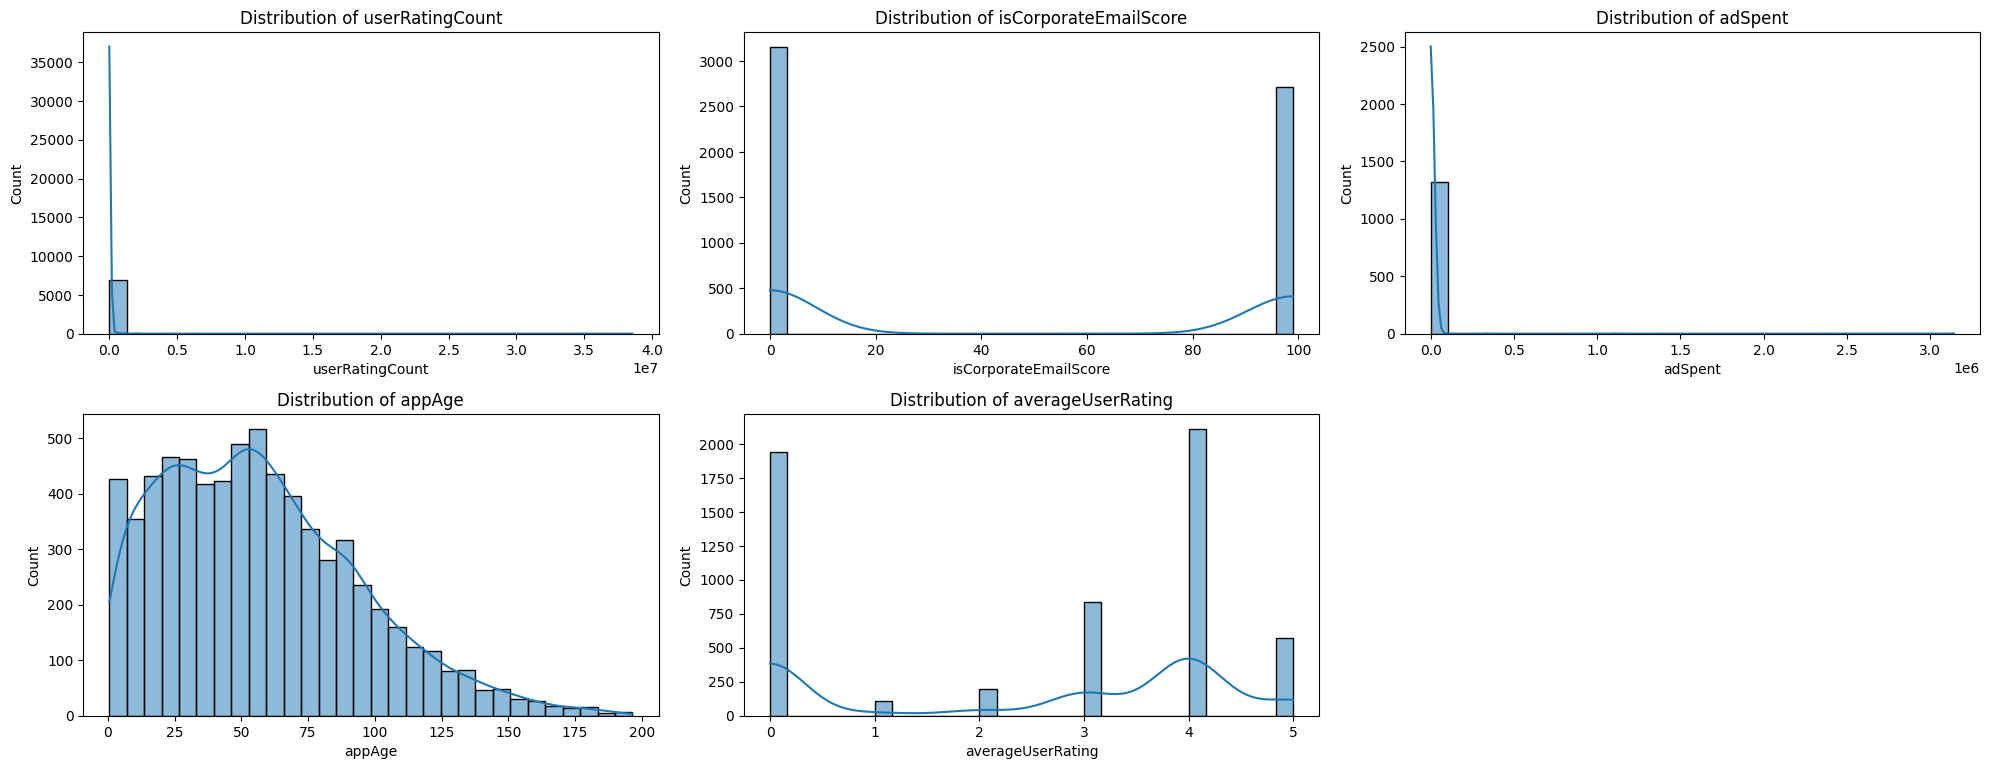

In [79]:
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
axes = axes.flatten()

for idx, feature in enumerate(numerical):
    transformed_data = df_train[feature]
    transformed_label = f'{feature}'

    transformed_df = pd.DataFrame({feature: transformed_data})

    sns.histplot(data=transformed_df, x=feature, bins=30, kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {transformed_label}')
    axes[idx].set_xlabel(transformed_label)

for idx in range(len(numerical), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

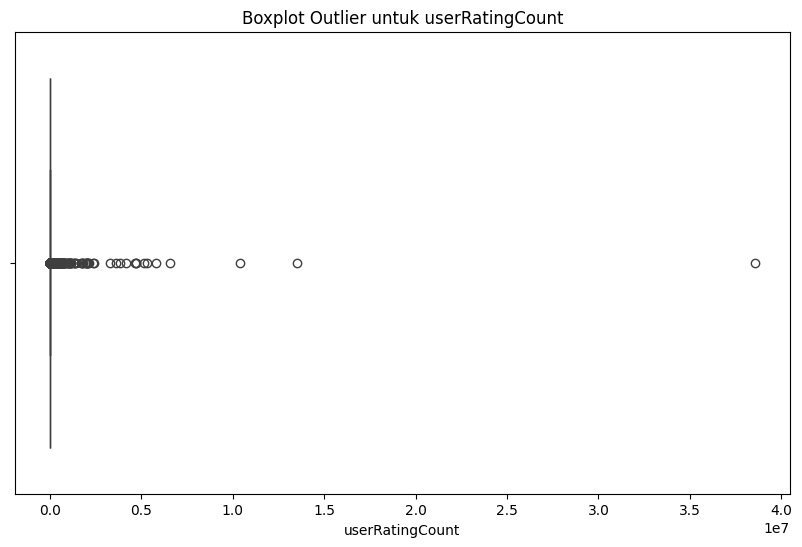

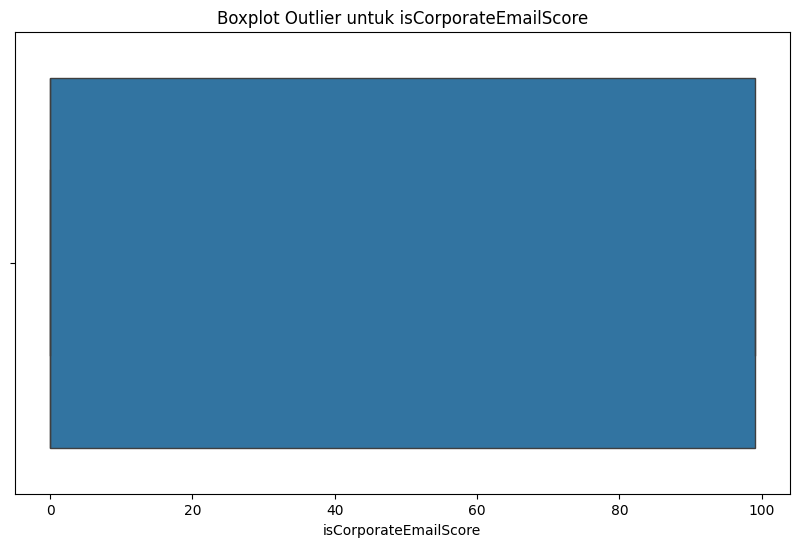

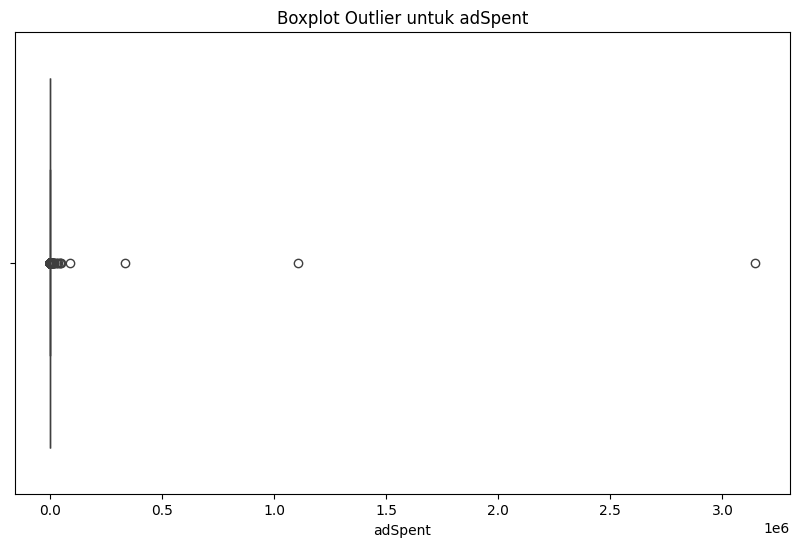

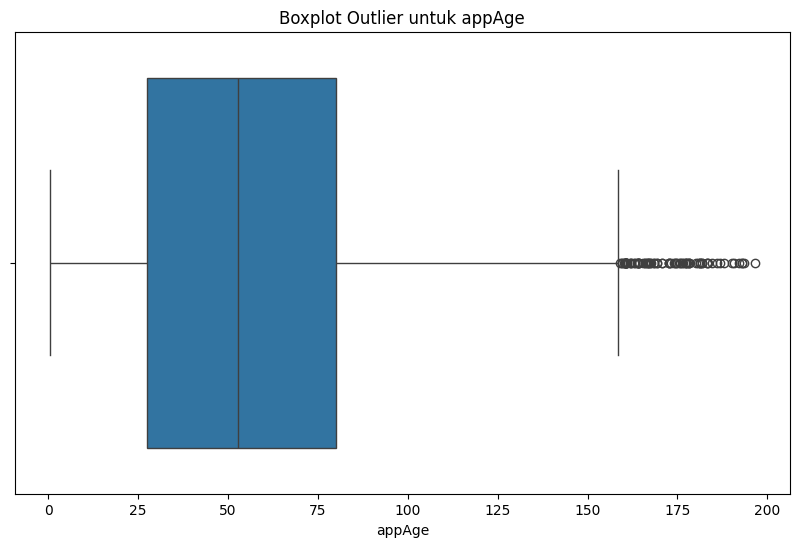

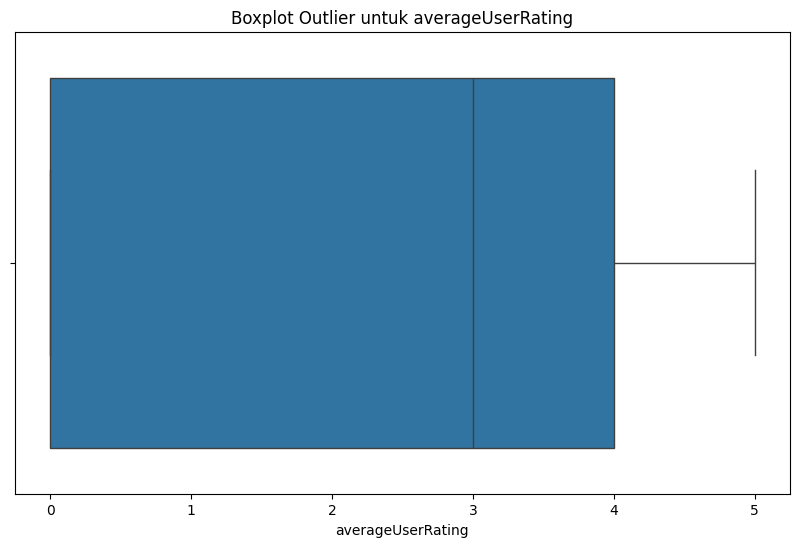

In [80]:
for feature in numerical:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_train[feature])
    plt.title(f'Boxplot Outlier untuk {feature}')
    plt.xlabel(feature)
    plt.show()

In [81]:
missing_per_column = df_train.isnull().sum()
print(missing_per_column)

developerCountry                      0
countryCode                          64
userRatingCount                       0
primaryGenreName                      0
downloads                          2149
deviceType                            0
hasPrivacyLink                      750
hasTermsOfServiceLink              4635
hasTermsOfServiceLinkRating        4635
isCorporateEmailScore              1128
adSpent                            5679
appAge                               50
averageUserRating                  1232
appContentBrandSafetyRating        6162
appDescriptionBrandSafetyRating       0
mfaRating                             0
coppaRisk                             0
dtype: int64


C:\Users\alfre\AppData\Local\Temp\ipykernel_31180\3941176368.py:19: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


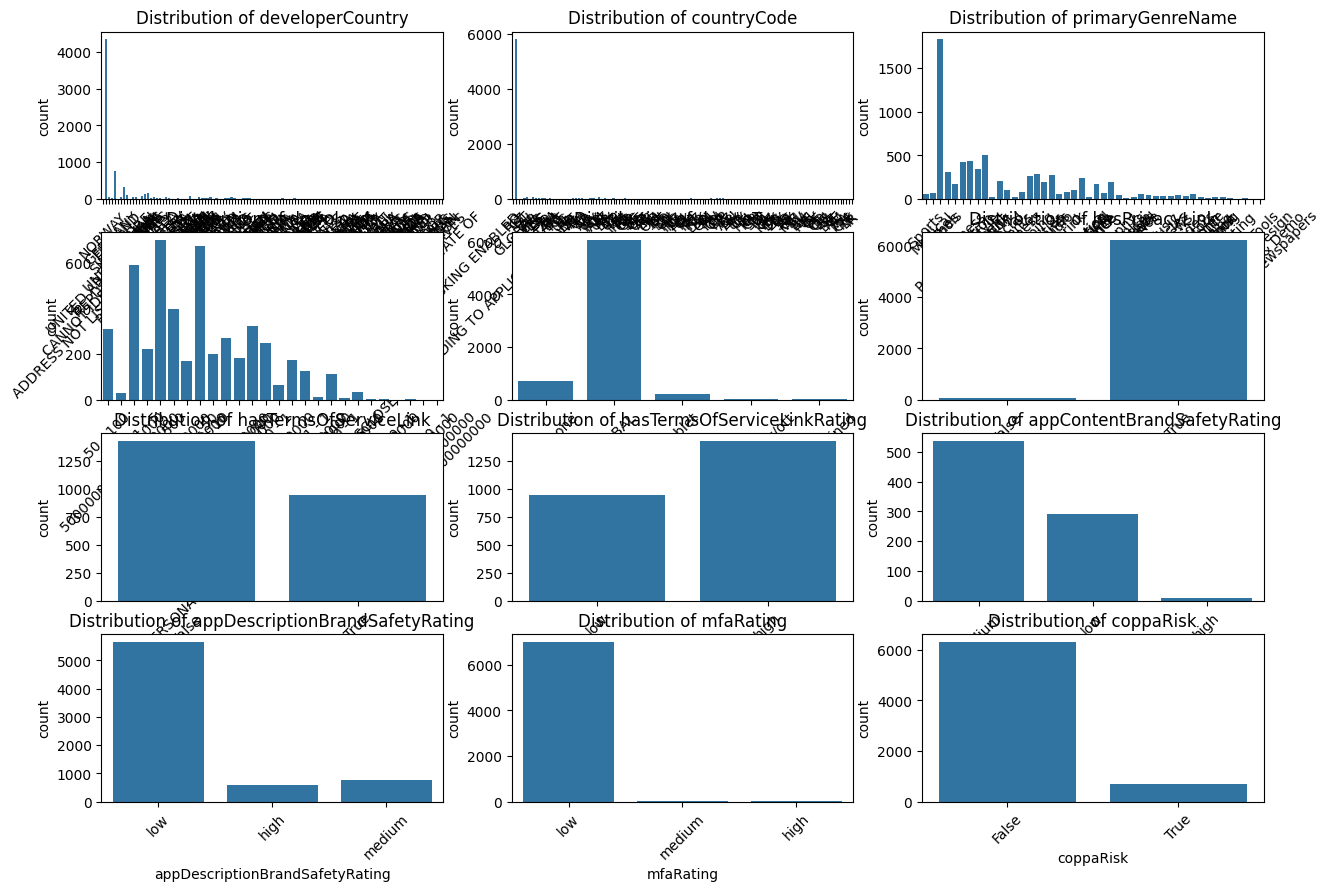

In [82]:
import math

num_features = len(categorical)
cols = 3  # atau kolom yang diinginkan
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(categorical):
    sns.countplot(data=df_train, x=feature, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].tick_params(axis='x', rotation=45)  # rotasi label agar lebih jelas

# Hapus axes yang tidak terpakai jika ada
for idx in range(len(categorical), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


# Preprocess and Modelling

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

train_set = df_train.copy()

X_train = train_set.drop(columns=["coppaRisk"])
y_train = train_set["coppaRisk"]

le = LabelEncoder()
y_train = le.fit_transform(y_train)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

numerical_columns = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist()

In [84]:
def create_submission(pipeline,
                      df_test,
                      df_submission_template,
                      target_col="coppaRisk",
                      output_filename="submission.csv",
                      verbose=False,
                      n_head=20):
    probs = pipeline.predict_proba(df_test)[:, 1]
    submission = df_submission_template.copy()
    submission[target_col] = probs

    if verbose:
        submission.head(n_head)

    submission.to_csv(output_filename, index=False)
    print(f"File {output_filename} generated!")

    return submission


In [85]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, RobustScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import MissingIndicator, SimpleImputer, KNNImputer
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest, VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from imblearn.combine import SMOTETomek

class ColumnRemover(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop if columns_to_drop is not None else []
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        if not self.columns_to_drop:
            return X
        
        if isinstance(X, pd.DataFrame):
            return X.drop(columns=self.columns_to_drop, errors='ignore')
        
        return X
    
    def get_params(self, deep=True):
        return {'columns_to_drop': self.columns_to_drop}
    
    def set_params(self, **params):
        self.columns_to_drop = params['columns_to_drop']
        return self

    
from sklearn.utils.validation import check_array

class SafePolynomialFeatures(PolynomialFeatures):
    def transform(self, X):
        X = check_array(X, accept_sparse=True, dtype=np.float64, 
                       force_all_finite='allow-nan')
        X_filled = np.nan_to_num(X)
        return super().transform(X_filled)
    
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0.05):
        self.contamination = contamination
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
            
        for col in X.select_dtypes(include=['float64', 'int64']).columns:
            q1 = X[col].quantile(0.01)
            q3 = X[col].quantile(0.99)
            X[col] = X[col].clip(q1, q3)
            
        return X

class ImprovedImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.num_imputer = KNNImputer(n_neighbors=10)
        self.cat_imputer = SimpleImputer(strategy='most_frequent')
        self.numeric_columns = None
        self.categorical_columns = None
        
    def fit(self, X, y=None):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        
        self.numeric_columns = X_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.categorical_columns = X_df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
        
        if self.numeric_columns:
            self.num_imputer.fit(X_df[self.numeric_columns])
        if self.categorical_columns:
            self.cat_imputer.fit(X_df[self.categorical_columns])
            
        return self
    
    def transform(self, X):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X.copy())
        
        for col in X_df.columns:
            missing_rate = X_df[col].isnull().mean()
            if missing_rate > 0.05:
                X_df[f'{col}_was_missing'] = X_df[col].isnull().astype(int)
        
        if self.numeric_columns:
            cols_to_impute = [col for col in self.numeric_columns if col in X_df.columns]
            if cols_to_impute:
                X_df[cols_to_impute] = self.num_imputer.transform(X_df[cols_to_impute])
        
        if self.categorical_columns:
            cols_to_impute = [col for col in self.categorical_columns if col in X_df.columns]
            if cols_to_impute:
                X_df[cols_to_impute] = self.cat_imputer.transform(X_df[cols_to_impute])

        if 'hasPrivacyLink' in X_df.columns and X_df['hasPrivacyLink'].isnull().any():
            X_df['hasPrivacyLink'] = X_df['hasPrivacyLink'].fillna(0)
            
        if 'isCorporateEmailScore' in X_df.columns and X_df['isCorporateEmailScore'].isnull().any():
            X_df['isCorporateEmailScore'] = X_df['isCorporateEmailScore'].fillna(25)
        
        return X_df
    
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_transformed = X.copy()
        else:
            try:
                X_transformed = pd.DataFrame(X)
            except:
                return X
        
        if 'downloads' in X_transformed.columns:
            X_transformed['min_downloads'] = X_transformed['downloads'].apply(
                lambda x: int(str(x).split('-')[0].strip().replace(',', '')) 
                if isinstance(x, str) and '-' in x else np.nan
            )
            X_transformed['max_downloads'] = X_transformed['downloads'].apply(
                lambda x: int(str(x).split('-')[-1].strip().replace(',', '')) 
                if isinstance(x, str) and '-' in x else np.nan
            )
            X_transformed['log_min_downloads'] = np.log1p(X_transformed['min_downloads'].fillna(0))
            X_transformed['log_max_downloads'] = np.log1p(X_transformed['max_downloads'].fillna(0))
        
        if 'developerCountry' in X_transformed.columns:
            X_transformed['dev_in_US'] = X_transformed['developerCountry'].apply(
                lambda x: 1 if str(x) == 'US' else 0
            )
            X_transformed['dev_unknown'] = X_transformed['developerCountry'].apply(
                lambda x: 1 if str(x) in ['ADDRESS NOT LISTED IN PLAYSTORE', 'CANNOT IDENTIFY COUNTRY'] else 0
            )

        if 'countryCode' in X_transformed.columns:
            X_transformed['global_market'] = X_transformed['countryCode'].apply(
                lambda x: 1 if str(x) == 'GLOBAL' else 0
            )
            X_transformed['north_america_market'] = X_transformed['countryCode'].apply(
                lambda x: 1 if str(x) == 'NA' else 0
            )
            X_transformed['coppa_jurisdiction'] = X_transformed['countryCode'].apply(
                lambda x: 1 if str(x) in ['NA', 'GLOBAL'] else 0
            )
        
        compliance_cols = ['hasPrivacyLink', 'hasTermsOfServiceLink']
        if all(col in X_transformed.columns for col in compliance_cols):
            for col in compliance_cols:
                if X_transformed[col].dtype == 'object':
                    X_transformed[col] = X_transformed[col].apply(
                        lambda x: 1 if str(x).lower() in ['true', '1', 'yes', 't'] else 0
                    )
            X_transformed['compliance_score'] = X_transformed[compliance_cols].sum(axis=1)
            X_transformed['missing_privacy_policy'] = (1 - X_transformed['hasPrivacyLink']).astype(int)
        
        if 'hasTermsOfServiceLinkRating' in X_transformed.columns:
            X_transformed['tos_quality_numeric'] = X_transformed['hasTermsOfServiceLinkRating'].map(
                {'low': 1, 'medium': 2, 'high': 3}
            )
        
        if 'appAge' in X_transformed.columns:
            if X_transformed['appAge'].dtype == 'object':
                X_transformed['appAge'] = pd.to_numeric(X_transformed['appAge'], errors='coerce')
            
            X_transformed['app_age_years'] = X_transformed['appAge'] / 365
            X_transformed['is_new_app'] = (X_transformed['appAge'] < 90).astype(int)  # < 3 months
            X_transformed['is_established_app'] = (X_transformed['appAge'] > 365).astype(int)  # > 1 year
        
        if 'deviceType' in X_transformed.columns:
            X_transformed['is_tablet'] = X_transformed['deviceType'].apply(
                lambda x: 1 if isinstance(x, str) and 'tablet' in x.lower() else 0
            )
            X_transformed['is_smartphone'] = X_transformed['deviceType'].apply(
                lambda x: 1 if isinstance(x, str) and 'smartphone' in x.lower() else 0
            )
            X_transformed['is_multi_device'] = X_transformed['deviceType'].apply(
                lambda x: 1 if isinstance(x, str) and ',' in x else 0
            )
        
        if 'primaryGenreName' in X_transformed.columns:
            child_related_genres = ['Games', 'Education', 'Family', 'Entertainment', 'Kids']
            X_transformed['is_child_related_genre'] = X_transformed['primaryGenreName'].apply(
                lambda x: 1 if str(x) in child_related_genres else 0
            )

            X_transformed['is_game'] = X_transformed['primaryGenreName'].apply(
                lambda x: 1 if str(x) == 'Games' else 0
            )
            X_transformed['is_education'] = X_transformed['primaryGenreName'].apply(
                lambda x: 1 if str(x) == 'Education' else 0
            )
            X_transformed['is_family'] = X_transformed['primaryGenreName'].apply(
                lambda x: 1 if str(x) == 'Family' else 0
            )

        if 'isCorporateEmailScore' in X_transformed.columns:
            if X_transformed['isCorporateEmailScore'].dtype == 'object':
                X_transformed['isCorporateEmailScore'] = pd.to_numeric(X_transformed['isCorporateEmailScore'], errors='coerce')
            
            X_transformed['is_professional_developer'] = (X_transformed['isCorporateEmailScore'] > 75).astype(int)
            X_transformed['is_amateur_developer'] = (X_transformed['isCorporateEmailScore'] < 25).astype(int)
        
        if 'averageUserRating' in X_transformed.columns and 'userRatingCount' in X_transformed.columns:
            for col in ['averageUserRating', 'userRatingCount']:
                if X_transformed[col].dtype == 'object':
                    X_transformed[col] = pd.to_numeric(X_transformed[col], errors='coerce')

            X_transformed['weighted_rating'] = X_transformed['averageUserRating'] * np.log1p(X_transformed['userRatingCount'].fillna(0))
            X_transformed['high_engagement'] = (X_transformed['userRatingCount'] > 1000).astype(int)
        
        safety_cols = ['appContentBrandSafetyRating', 'appDescriptionBrandSafetyRating', 'mfaRating']
        if all(col in X_transformed.columns for col in safety_cols):
            for col in safety_cols:
                X_transformed[f'{col}_numeric'] = X_transformed[col].map({'low': 1, 'medium': 2, 'high': 3})
            
            numeric_cols = [f'{col}_numeric' for col in safety_cols]
            X_transformed['brand_safety_score'] = X_transformed[numeric_cols].mean(axis=1)
        
        if 'adSpent' in X_transformed.columns:
            if X_transformed['adSpent'].dtype == 'object':
                X_transformed['adSpent'] = pd.to_numeric(X_transformed['adSpent'], errors='coerce')
            
            X_transformed['log_ad_spent'] = np.log1p(X_transformed['adSpent'].fillna(0))
            X_transformed['high_ad_spender'] = (X_transformed['adSpent'] > X_transformed['adSpent'].median()).astype(int)
        
        if 'dev_in_US' in X_transformed.columns and 'is_child_related_genre' in X_transformed.columns:
            X_transformed['us_child_app'] = (X_transformed['dev_in_US'] & X_transformed['is_child_related_genre']).astype(int)
        
        if 'is_new_app' in X_transformed.columns and 'is_child_related_genre' in X_transformed.columns:
            X_transformed['new_child_app'] = (X_transformed['is_new_app'] & X_transformed['is_child_related_genre']).astype(int)

        if 'log_min_downloads' in X_transformed.columns and 'missing_privacy_policy' in X_transformed.columns:
            X_transformed['popular_no_privacy'] = (
                (X_transformed['log_min_downloads'] > X_transformed['log_min_downloads'].median()) &
                X_transformed['missing_privacy_policy']
            ).astype(int)

        if 'is_child_related_genre' in X_transformed.columns and 'is_amateur_developer' in X_transformed.columns:
            X_transformed['child_app_amateur_dev'] = (
                X_transformed['is_child_related_genre'] & X_transformed['is_amateur_developer']
            ).astype(int)

        if 'is_child_related_genre' in X_transformed.columns and 'high_engagement' in X_transformed.columns:
            X_transformed['popular_child_app'] = (
                X_transformed['is_child_related_genre'] & X_transformed['high_engagement']
            ).astype(int)
            
        return X_transformed
    
class EnhancedFeatureExtractor(FeatureExtractor):
    def transform(self, X):
        X = super().transform(X)
        
        if isinstance(X, pd.DataFrame):
            reference_date = pd.to_datetime('2023-11-01') 
            
            if 'appAge' in X.columns:
                X['release_day_of_year'] = (reference_date - pd.to_timedelta(X['appAge'], unit='D')).dt.dayofyear
                X['release_sin'] = np.sin(2 * np.pi * X['release_day_of_year']/365)
                X['release_cos'] = np.cos(2 * np.pi * X['release_day_of_year']/365)
                
                X['post_coppa_2013'] = (X['appAge'] < (reference_date - pd.to_datetime('2013-07-01')).days).astype(int)
                X['post_ftc_crackdown'] = (X['appAge'] < (reference_date - pd.to_datetime('2021-01-01')).days).astype(int)

                X['app_age_quantile'] = pd.qcut(X['appAge'], 4, labels=False)
                X['log_app_age'] = np.log1p(X['appAge'])
            
            if 'lastUpdated' in X.columns:
                update_date = pd.to_datetime(X['lastUpdated'], errors='coerce')
                days_since_update = (reference_date - update_date).dt.days
                
                X['days_since_update'] = days_since_update
                X['update_frequency'] = X['appAge'] / (X['versionCount'] + 1e-6)
                X['stale_app'] = (days_since_update > 365).astype(int)
                X.update_frequency = np.where(X.update_frequency == np.inf, 365, X.update_frequency)

                X['update_regularity'] = X.groupby('developerId')['days_since_update'].transform('std').fillna(0)

            if 'firstMadeAvailable' in X.columns:
                available_date = pd.to_datetime(X['firstMadeAvailable'], errors='coerce')
                X['years_on_market'] = (reference_date - available_date).dt.days / 365
                X['compliance_era'] = ((reference_date.year - available_date.dt.year) > 3).astype(int)
            
            if 'userRatingCount' in X.columns and 'averageUserRating' in X.columns:
                X['recent_rating_velocity'] = X['userRatingCount'] / (X['appAge'] + 1e-6)
                X['rating_trend'] = X['averageUserRating'].rolling(window=30, min_periods=1).mean()

                if 'lastUpdated' in locals():
                    rating_decay = 0.95 ** days_since_update
                    X['weighted_rating'] = X['averageUserRating'] * rating_decay

            if 'developerId' in X.columns:
                dev_stats = X.groupby('developerId')['appAge'].agg(['mean', 'count', 'std']).reset_index()
                dev_stats.columns = ['developerId', 'dev_exp_mean', 'apps_count', 'dev_exp_std']
                X = X.merge(dev_stats, on='developerId', how='left')

                dev_start = X.groupby('developerId')['appAge'].max().reset_index(name='dev_start_age')
                X = X.merge(dev_start, on='developerId', how='left')
                X['dev_seniority'] = X['appAge'] - X['dev_start_age']
            
            if all(c in X.columns for c in ['dev_in_US', 'app_age_quantile']):
                X['us_modern_app'] = X['dev_in_US'] * (X['app_age_quantile'] > 2).astype(int)
                
            if 'post_ftc_crackdown' in X.columns and 'is_child_related_genre' in X.columns:
                X['recent_child_app'] = X['post_ftc_crackdown'] * X['is_child_related_genre']
            
            if all(c in X.columns for c in ['years_on_market', 'compliance_score']):
                X['compliance_trend'] = X['compliance_score'] * np.log1p(X['years_on_market'])
                
            if 'release_day_of_year' in X.columns:
                X['holiday_release'] = X['release_day_of_year'].apply(
                    lambda d: 1 if d in range(300, 320) or d in range(150, 180) else 0
                )
        
        for col in X.select_dtypes(include=[np.number]).columns:
            X[col] = X[col].replace([np.inf, -np.inf], np.nan)
            X[col] = X[col].fillna(X[col].median()) if X[col].dtype.kind in 'iufc' else X[col]
            
        return X

numerical_pipeline = Pipeline([
    ('quantile_transform', QuantileTransformer(output_distribution='normal', random_state=42)),
    # ('power_transform', PowerTransformer(method='yeo-johnson')),
    # ('log_transform', FunctionTransformer(np.log1p, validate=True)),
    ('scaler', RobustScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

from category_encoders import TargetEncoder
high_card_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
    ('tgt_enc', TargetEncoder(smoothing=0.3))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, [col for col in numerical_columns if col not in columns_to_drop]),
        ('cat', categorical_pipeline, [col for col in categorical_columns if col not in columns_to_drop]),
        ('cat_high', high_card_pipeline, [col for col in categorical_columns if X_train[col].nunique() >= 5 and col not in columns_to_drop])
    ]
)

columns_to_drop = [
    # 'developerCountry',
    # 'countryCode',
    # 'userRatingCount',
    # 'primaryGenreName', # Primary
    # 'downloads',
    # 'deviceType',
    # 'hasPrivacyLink',
    # 'hasTermsOfServiceLink',
    # 'hasTermsOfServiceLinkRating',
    # 'isCorporateEmailScore',
    # 'adSpent',
    # 'appAge',
    # 'averageUserRating',
    # 'appContentBrandSafetyRating',
    # 'appDescriptionBrandSafetyRating', #Primary
    # 'mfaRating',
]

def create_train_pipeline(classifier):
    return ImbPipeline([
        ('feature_engineer', EnhancedFeatureExtractor()),
        ('column_remover', ColumnRemover(columns_to_drop)),
        ('imputer', ImprovedImputer()),
        ('preprocessor', preprocessor),
        ('variance_selector', VarianceThreshold(threshold=0.01)),
        # ('mutual_info_selector', SelectKBest(mutual_info_classif, k=40)),
        # ('rfe_selector', RFECV(estimator=LogisticRegression(max_iter=1000, class_weight='balanced'), 
        #                     step=0.1, cv=5, scoring='roc_auc')),
        # ('feature_selector', SelectFromModel(xgb.XGBClassifier(random_state=42))),
        # ('resampler', SMOTETomek(random_state=42)),
        ('poly', SafePolynomialFeatures(degree=2, interaction_only=True)),
        ('classifier', classifier)
    ])


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\alfre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alfre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best parameters: OrderedDict({'classifier__boosting_type': 'dart', 'classifier__colsample_bylevel': 0.9593612608346885, 'classifier__colsample_bytree': 0.5524295792763518, 'classifier__learning_rate': 0.03662511300327987, 'classifier__max_depth': 4, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 480, 'classifier__num_leaves': 95, 'classifier__reg_alpha': 0.16957494783371216, 'classifier__reg_lambda': 7.813181458539903, 'classifier__subsample': 0.8517337655531521})
Best CV score: 0.8926
CV Results for Best Model:
Mean Test Score for Best Model: 0.8926
Std Test Score for Best Model: 0.0053
Max Test Score for Best Model: 0.8978


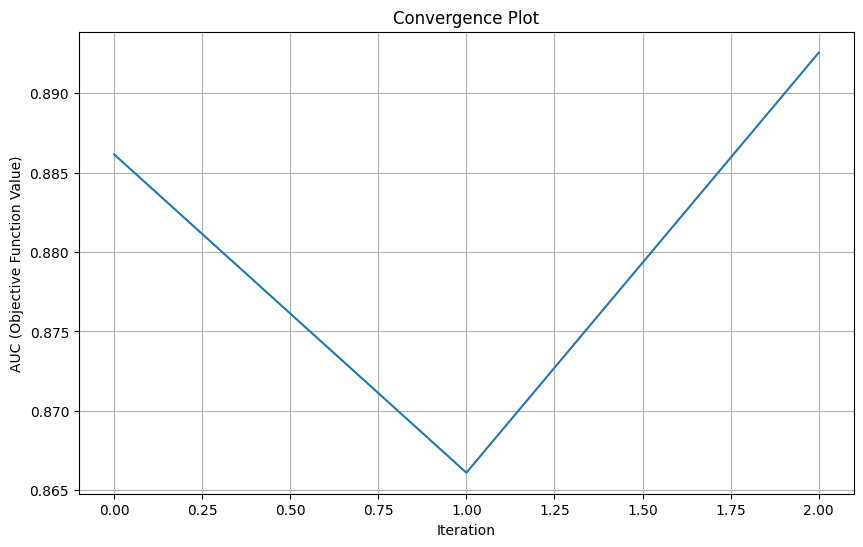

c:\Users\alfre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alfre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


File submission_lgb_MAX2.csv generated!


c:\Users\alfre\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\alfre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\alfre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,ID,coppaRisk
0,2807,0.012933
1,1742,0.242183
2,806,0.360731
3,2635,0.067191
4,9047,0.012933
...,...,...
2995,2288,0.012948
2996,5541,0.013209
2997,9259,0.012933
2998,3477,0.012933


In [86]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

search_spaces = {
    'classifier__learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'classifier__n_estimators': Integer(200, 2000),
    'classifier__max_depth': Integer(3, 10),
    'classifier__num_leaves': Integer(20, 120),
    'classifier__min_child_weight': Integer(1, 10),
    'classifier__subsample': Real(0.5, 1.0),
    'classifier__colsample_bytree': Real(0.5, 1.0),
    'classifier__colsample_bylevel': Real(0.5, 1.0),
    'classifier__reg_alpha': Real(1e-3, 10.0, prior='log-uniform'),
    'classifier__reg_lambda': Real(1e-3, 10.0, prior='log-uniform'),
    'classifier__boosting_type': Categorical(['gbdt', 'dart', 'goss'])
}

base_classifier = lgb.LGBMClassifier(
    random_state=42,
    verbose=-1,
    metric='auc'
)

imb_pipeline = create_train_pipeline(base_classifier)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bayes_search = BayesSearchCV(
    estimator=imb_pipeline,
    search_spaces=search_spaces,
    n_iter=3, #10 for test, 100 for submission
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

bayes_search.fit(X_train, y_train)

print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best CV score: {bayes_search.best_score_:.4f}")

best_index = bayes_search.best_index_
cv_results = bayes_search.cv_results_

print("CV Results for Best Model:")
print(f"Mean Test Score for Best Model: {cv_results['mean_test_score'][best_index]:.4f}")
print(f"Std Test Score for Best Model: {cv_results['std_test_score'][best_index]:.4f}")
print(f"Max Test Score for Best Model: {cv_results['mean_test_score'][best_index] + cv_results['std_test_score'][best_index]:.4f}")

import matplotlib.pyplot as plt
convergence = bayes_search.cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
plt.plot(convergence)
plt.xlabel('Iteration')
plt.ylabel('AUC (Objective Function Value)')
plt.title('Convergence Plot')
plt.grid(True)
plt.show()


# Evaluate on validation set (if k-fold not used)
# y_pred_prob_val = bayes_search.predict_proba(X_val)[:, 1]
# auc_val = roc_auc_score(y_val, y_pred_prob_val)
# print(f"AUC (Validation): {auc_val:.4f}")

# Submission
best_pipeline = bayes_search.best_estimator_
best_pipeline.fit(X_train, y_train)

create_submission(
    pipeline=best_pipeline,
    df_test=df_test,
    df_submission_template=df_submission,
    output_filename='submission_lgb_MAX2.csv'
)